In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, print_stats=True, bounds=None, title=None, print_spearman=False, name=None, dims = (1, 3)):
    # fig, axes = plt.subplots(1, len(reals_list), figsize=(10 * len(reals_list), 8))
    #assert that len(reals_list) is smaller then the number of subplots
    assert len(reals_list) <= dims[0]*dims[1]
    fig, axes = plt.subplots(dims[0], dims[1], figsize=(10 * dims[1], 8 * dims[0]))
    axes = axes.flatten()
    for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
        ax = axes[i] if len(reals_list) > 1 else axes


    # for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
    #     ax = axes[i] if len(reals_list) > 1 else axes

        rmses, maes, ebos, kts, median_aes = [], [], [], [], []

        for r, p in zip(reals, predictions):
            RMSE, MAE, EBO, KT, median_AE = getStatValues_v2(r, p)
            rmses.append(RMSE)
            maes.append(MAE)
            ebos.append(EBO)
            kts.append(KT)
            median_aes.append(median_AE)

        rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
        rmse_mean = np.mean(rmses)
        mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
        mae_mean = np.mean(maes)
        ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
        ebo_mean = np.mean(ebos)
        kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
        kt_mean = np.mean(kts)
        median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
        median_AE_mean = np.mean(median_aes)

        mrn = [item for sublist in molregnos for item in sublist]
        real = [item for sublist in reals for item in sublist]
        prediction = [item for sublist in predictions for item in sublist]

        df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
        df = df.groupby('molregno').mean()
        real = df['real'].tolist()
        prediction = df['prediction'].tolist()

        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')

        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")

        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]

        ax.axis([lower, upper, lower, upper])

        text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})',
                           transform=ax.transAxes, fontsize=12, verticalalignment='top',
                           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        if title is not None:
            ax.set_title(title[i] if len(reals_list) > 1 else title, fontsize=14)

        ax.set_aspect('equal', 'box')

    if name:
        plt.savefig(f'{name}.png', dpi=800, bbox_inches='tight')
    else:
        plt.show()


In [2]:
#find all conf_ids that are NOT in cs_mdfps_schema.confid_data;
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=scotland")
cur = conn.cursor()
query = """

SELECT 
    e.molregno,
    c.conf_id,
    e.vp_log10_pa,
    m.mdfp,
    c.molblock,
    m.md_experiment_uuid,
    cd.confgen_uuid -- Add this column for confgen_uuid
FROM 
    cs_mdfps_schema.experimental_data e
JOIN 
    conformers c ON e.molregno = c.molregno
LEFT JOIN 
    cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id
LEFT JOIN 
    cs_mdfps_schema.confid_data cd ON c.conf_id = cd.conf_id; -- Join with confid_data for confgen_uuid


"""

cur.execute(query)
data = cur.fetchall()
import pandas as pd

df = pd.DataFrame(data, columns=['molregno', 'conf_id', 'vp_log10_pa', 'mdfp', 'molblock', 'md_experiment_uuid', 'confgen_uuid'])
df

df = df[df['md_experiment_uuid'] == '24e3946b-fb2c-47bf-9965-1682bb0d63c9']
df = df.dropna(subset=['mdfp'])
df


,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid
1,2390,2388,2.325202,"{'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24....",[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
4,2396,2394,2.092402,"{'mdfp': '[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.70...",[H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
7,2399,2397,-3.979000,"{'mdfp': '[19, 1, 0, 0, 0, 0, 0, 7, 0, 0, -18....",[H]c1c(Cl)c(Cl)c(Cl)c(-c2c([H])c(Cl)c(Cl)c(Cl)...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
10,2422,2420,3.031002,"{'mdfp': '[7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 226.3...",[H]c1nc([H])c(C([H])([H])[H])nc1[H]\n RDKi...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
13,2400,2398,2.056402,"{'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -30....",[H]c1c([H])c(C([H])([H])C([H])([H])[H])c(C([H]...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
...,...,...,...,...,...,...,...
15985,2434,2432,-4.499000,"{'mdfp': '[21, 1, 0, 0, 0, 0, 0, 9, 0, 0, -9.7...",[H]c1c(Cl)c(Cl)c(Cl)c(-c2c(Cl)c(Cl)c(Cl)c(Cl)c...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
15988,2442,2440,3.086302,"{'mdfp': '[6, 1, 0, 1, 0, 0, 0, 0, 0, 0, -37.7...",[H]O[C@]([H])(C([H])([H])[H])C([H])(C([H])([H]...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
15991,2460,2458,3.845102,"{'mdfp': '[7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1.588...",[H]C#CC([H])([H])C([H])([H])C([H])([H])C([H])(...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
15993,2475,2473,2.935502,"{'mdfp': '[9, 3, 0, 2, 0, 0, 0, 0, 0, 0, -60.9...",[H]C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835


In [3]:
#add descriptors and save the csvs
#get the molblocks, get mols, calculcate PhysChem Descriptors, add to df
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
import json
df['mdfp_vec'] = df['mdfp'].apply(lambda val: json.loads(val['mdfp']) if (val and 'mdfp' in val) else None)
mdfp_features_liquid = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI',
 'liquid_intra_crf_mean',
 'liquid_intra_crf_std',
 'liquid_intra_crf_median',
 'liquid_intra_lj_mean',
 'liquid_intra_lj_std',
 'liquid_intra_lj_median',
 'liquid_total_crf_mean',
 'liquid_total_crf_std',
 'liquid_total_crf_median',
 'liquid_total_lj_mean',
 'liquid_total_lj_std',
 'liquid_total_lj_median',
 'liquid_intra_ene_mean',
 'liquid_intra_ene_std',
 'liquid_intra_ene_median',
 'liquid_total_ene_mean',
 'liquid_total_ene_std',
 'liquid_total_ene_median',
 'liquid_rgyr_mean',
 'liquid_rgyr_std',
 'liquid_rgyr_median',
 'liquid_sasa_mean',
 'liquid_sasa_std',
 'liquid_sasa_median',
 'liquid_dipole_magnitude_mean',
 'liquid_dipole_magnitude_std',
 'liquid_dipole_magnitude_median']
# # Assuming 'mdfp_vec' is the column containing the lists
df[mdfp_features_liquid] = pd.DataFrame(df['mdfp_vec'].apply(lambda x: x if x is not None else pd.Series(dtype=float)).to_list(), index=df.index)
df

,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,mdfp_vec,NumHeavyAtoms,NumRotatableBonds,...,liquid_total_ene_median,liquid_rgyr_mean,liquid_rgyr_std,liquid_rgyr_median,liquid_sasa_mean,liquid_sasa_std,liquid_sasa_median,liquid_dipole_magnitude_mean,liquid_dipole_magnitude_std,liquid_dipole_magnitude_median
1,2390,2388,2.325202,"{'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24....",[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3428715880...",10,1,...,-84.904874,0.239103,0.002049,0.239245,3.536154,0.016848,3.535872,0.113783,0.048283,0.108422
4,2396,2394,2.092402,"{'mdfp': '[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.70...",[H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835,"[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.707043552162...",7,4,...,-114.692771,0.237496,0.013948,0.237724,3.131462,0.057642,3.136658,0.996428,0.388802,0.980973
7,2399,2397,-3.979000,"{'mdfp': '[19, 1, 0, 0, 0, 0, 0, 7, 0, 0, -18....",[H]c1c(Cl)c(Cl)c(Cl)c(-c2c([H])c(Cl)c(Cl)c(Cl)...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835,"[19, 1, 0, 0, 0, 0, 0, 7, 0, 0, -18.4325043183...",19,1,...,-159.746620,0.377663,0.001526,0.377669,4.999057,0.018791,5.000805,1.148938,0.107620,1.143437
10,2422,2420,3.031002,"{'mdfp': '[7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 226.3...",[H]c1nc([H])c(C([H])([H])[H])nc1[H]\n RDKi...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835,"[7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 226.33122231142...",7,0,...,149.549874,0.173081,0.000525,0.173096,2.592501,0.010757,2.592847,0.139275,0.055779,0.136875
13,2400,2398,2.056402,"{'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -30....",[H]c1c([H])c(C([H])([H])C([H])([H])[H])c(C([H]...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -30.5767910085...",10,1,...,-93.901233,0.233452,0.001585,0.233507,3.515940,0.020061,3.514785,0.084445,0.037925,0.080527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,2434,2432,-4.499000,"{'mdfp': '[21, 1, 0, 0, 0, 0, 0, 9, 0, 0, -9.7...",[H]c1c(Cl)c(Cl)c(Cl)c(-c2c(Cl)c(Cl)c(Cl)c(Cl)c...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835,"[21, 1, 0, 0, 0, 0, 0, 9, 0, 0, -9.79135173841...",21,1,...,-141.506655,0.364889,0.001322,0.364826,5.184148,0.017737,5.184085,0.483741,0.067401,0.485865
15988,2442,2440,3.086302,"{'mdfp': '[6, 1, 0, 1, 0, 0, 0, 0, 0, 0, -37.7...",[H]O[C@]([H])(C([H])([H])[H])C([H])(C([H])([H]...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835,"[6, 1, 0, 1, 0, 0, 0, 0, 0, 0, -37.79354588971...",6,1,...,-124.489857,0.173954,0.002141,0.173570,2.739910,0.019108,2.739719,0.672997,0.310317,0.637829
15991,2460,2458,3.845102,"{'mdfp': '[7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1.588...",[H]C#CC([H])([H])C([H])([H])C([H])([H])C([H])(...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835,"[7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1.5884282871045...",7,3,...,-76.986592,0.245460,0.012401,0.248411,3.172721,0.042792,3.182663,0.177616,0.079296,0.172410
15993,2475,2473,2.935502,"{'mdfp': '[9, 3, 0, 2, 0, 0, 0, 0, 0, 0, -60.9...",[H]C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835,"[9, 3, 0, 2, 0, 0, 0, 0, 0, 0, -60.98110419396...",9,3,...,-138.981259,0.252523,0.006890,0.254816,3.541376,0.043565,3.551675,0.667939,0.286812,0.638188


In [4]:
df_train = pd.read_csv('OPERA_Naef_Training.csv')
df_train

,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles,mdfp_vec,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,population_bin
0,2409,2407,-5.082698,"{'mdfp': '[23, 8, 1, 4, 0, 1, 2, 1, 0, 0, -727...",[H]c1c([H])c([H])c2c(c1[H])C(=O)N([C@]([H])(SP...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b7d0>,CCOP(=S)(OCC)S[C@H](CCl)N1C(=O)c2ccccc2C1=O,"[23, 8, 1, 4, 0, 1, 2, 1, 0, 0, -727.715289426...",...,0,0,0,0,0,0,0,0,0,1
1,2414,2412,-3.309299,"{'mdfp': '[17, 3, 3, 0, 0, 0, 0, 0, 0, 0, -109...",[H]c1c(C([H])([H])[H])nc(N([H])c2c([H])c([H])c...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b8b0>,Cc1cc(C2CC2)nc(Nc2ccccc2)n1,"[17, 3, 3, 0, 0, 0, 0, 0, 0, 0, -1099.20554641...",...,0,0,0,0,0,0,0,0,0,2
2,2461,2459,6.063902,"{'mdfp': '[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.39...",[H]C([H])=C([H])C([H])([H])[H]\n RDKit ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab8a39690>,C=CC,"[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.393493808224...",...,0,0,0,0,0,0,0,0,0,10
3,2422,2420,3.031002,"{'mdfp': '[7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 226.2...",[H]c1nc([H])c(C([H])([H])[H])nc1[H]\n RDKi...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b840>,Cc1cnccn1,"[7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 226.22868226398...",...,0,0,0,0,0,0,0,0,0,8
4,44,1187,3.830901,"{'mdfp': '[5, 2, 0, 0, 0, 0, 1, 0, 0, 0, 4.357...",[H]C([H])([H])SC([H])([H])C([H])([H])C([H])([H...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b990>,CCCSC,"[5, 2, 0, 0, 0, 0, 1, 0, 0, 0, 4.3574430766533...",...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,1038,2182,4.403701,"{'mdfp': '[6, 2, 0, 0, 0, 0, 0, 0, 0, 0, -1.60...",[H]C([H])([H])C([H])([H])C([H])(C([H])([H])[H]...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e400b0>,CCC(C)CC,"[6, 2, 0, 0, 0, 0, 0, 0, 0, 0, -1.602437129122...",...,0,0,0,0,0,0,0,0,0,10
2746,1039,2183,2.072302,"{'mdfp': '[12, 5, 0, 2, 0, 0, 0, 0, 0, 0, -93....",[H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H]...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e40120>,CC(C)CCOC(=O)CC(C)C,"[12, 5, 0, 2, 0, 0, 0, 0, 0, 0, -93.5803199716...",...,0,0,0,0,0,0,0,0,0,7
2747,2424,2422,0.301002,"{'mdfp': '[11, 2, 0, 1, 0, 0, 0, 0, 0, 0, 23.3...",[H]C(=O)/C(=C(\[H])c1c([H])c([H])c([H])c([H])c...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e40190>,C/C(C=O)=C\c1ccccc1,"[11, 2, 0, 1, 0, 0, 0, 0, 0, 0, 23.39729395313...",...,0,0,0,0,0,0,0,0,0,5
2748,1061,2205,-1.693000,"{'mdfp': '[15, 1, 0, 0, 0, 0, 0, 3, 0, 0, -51....",[H]c1c([H])c(-c2c([H])c(Cl)c([H])c(Cl)c2[H])c(...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e40200>,Clc1ccc(-c2cc(Cl)cc(Cl)c2)cc1,"[15, 1, 0, 0, 0, 0, 0, 3, 0, 0, -51.0381463541...",...,0,0,0,0,0,0,0,0,0,3


In [5]:
#combine with df on molregno
df_combined = pd.merge(df_train, df, on='molregno')
df_combined

,molregno,conf_id_x,vp_log10_pa_x,mdfp_x,molblock_x,md_experiment_uuid_x,confgen_uuid_x,ROMol,smiles,mdfp_vec_x,...,liquid_total_ene_median,liquid_rgyr_mean,liquid_rgyr_std,liquid_rgyr_median,liquid_sasa_mean,liquid_sasa_std,liquid_sasa_median,liquid_dipole_magnitude_mean,liquid_dipole_magnitude_std,liquid_dipole_magnitude_median
0,2414,2412,-3.309299,"{'mdfp': '[17, 3, 3, 0, 0, 0, 0, 0, 0, 0, -109...",[H]c1c(C([H])([H])[H])nc(N([H])c2c([H])c([H])c...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b8b0>,Cc1cc(C2CC2)nc(Nc2ccccc2)n1,"[17, 3, 3, 0, 0, 0, 0, 0, 0, 0, -1099.20554641...",...,-1249.116758,0.326552,0.007823,0.326799,4.747936,0.044701,4.756509,0.439350,0.152056,0.432354
1,2422,2420,3.031002,"{'mdfp': '[7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 226.2...",[H]c1nc([H])c(C([H])([H])[H])nc1[H]\n RDKi...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b840>,Cc1cnccn1,"[7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 226.22868226398...",...,149.549874,0.173081,0.000525,0.173096,2.592501,0.010757,2.592847,0.139275,0.055779,0.136875
2,44,1187,3.830901,"{'mdfp': '[5, 2, 0, 0, 0, 0, 1, 0, 0, 0, 4.357...",[H]C([H])([H])SC([H])([H])C([H])([H])C([H])([H...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b990>,CCCSC,"[5, 2, 0, 0, 0, 0, 1, 0, 0, 0, 4.3574430766533...",...,-49.654284,0.194614,0.008424,0.197645,2.768202,0.033168,2.772172,0.772010,0.317275,0.752871
3,79,1222,2.513502,"{'mdfp': '[7, 1, 0, 1, 0, 0, 0, 0, 0, 0, -28.1...",[H]OC([H])([H])C([H])([H])C(C([H])([H])[H])(C(...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab88f42e0>,CC(C)(C)CCO,"[7, 1, 0, 1, 0, 0, 0, 0, 0, 0, -28.10847434830...",...,-127.605171,0.203511,0.004175,0.204634,2.975514,0.022494,2.977813,1.074808,0.444433,1.019895
4,105,1250,2.911701,"{'mdfp': '[8, 4, 0, 1, 0, 0, 0, 0, 0, 0, -27.9...",[H]C([H])([H])C([H])([H])C([H])([H])C(=O)C([H]...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab88f4350>,CCCC(=O)CCC,"[8, 4, 0, 1, 0, 0, 0, 0, 0, 0, -27.99534626315...",...,-108.682554,0.249222,0.009624,0.251142,3.390639,0.046324,3.400928,1.309367,0.560127,1.262814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,1038,2182,4.403701,"{'mdfp': '[6, 2, 0, 0, 0, 0, 0, 0, 0, 0, -1.60...",[H]C([H])([H])C([H])([H])C([H])(C([H])([H])[H]...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e400b0>,CCC(C)CC,"[6, 2, 0, 0, 0, 0, 0, 0, 0, 0, -1.602437129122...",...,-40.323934,0.192838,0.002692,0.193012,2.914562,0.017757,2.914369,0.027287,0.011607,0.026773
2603,1039,2183,2.072302,"{'mdfp': '[12, 5, 0, 2, 0, 0, 0, 0, 0, 0, -93....",[H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H]...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e40120>,CC(C)CCOC(=O)CC(C)C,"[12, 5, 0, 2, 0, 0, 0, 0, 0, 0, -93.5803199716...",...,-188.635659,0.311779,0.015265,0.315003,4.282590,0.084049,4.312250,0.703773,0.307674,0.666644
2604,2424,2422,0.301002,"{'mdfp': '[11, 2, 0, 1, 0, 0, 0, 0, 0, 0, 23.3...",[H]C(=O)/C(=C(\[H])c1c([H])c([H])c([H])c([H])c...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e40190>,C/C(C=O)=C\c1ccccc1,"[11, 2, 0, 1, 0, 0, 0, 0, 0, 0, 23.39729395313...",...,-74.342048,0.266600,0.003324,0.265981,3.516474,0.021531,3.515534,1.129907,0.411122,1.120131
2605,1061,2205,-1.693000,"{'mdfp': '[15, 1, 0, 0, 0, 0, 0, 3, 0, 0, -51....",[H]c1c([H])c(-c2c([H])c(Cl)c([H])c(Cl)c2[H])c(...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e40200>,Clc1ccc(-c2cc(Cl)cc(Cl)c2)cc1,"[15, 1, 0, 0, 0, 0, 0, 3

In [6]:
for c in df_combined.columns:
    if c[-2:] == '_x':
        df_combined = df_combined.drop(c, axis=1)
    if c[-2:] == '_y':
        df_combined = df_combined.rename(columns={c: c[:-2]})
df_combined

,molregno,ROMol,smiles,water_intra_crf_mean,water_intra_crf_std,water_intra_crf_median,water_intra_lj_mean,water_intra_lj_std,water_intra_lj_median,water_total_crf_mean,...,liquid_total_ene_median,liquid_rgyr_mean,liquid_rgyr_std,liquid_rgyr_median,liquid_sasa_mean,liquid_sasa_std,liquid_sasa_median,liquid_dipole_magnitude_mean,liquid_dipole_magnitude_std,liquid_dipole_magnitude_median
0,2414,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b8b0>,Cc1cc(C2CC2)nc(Nc2ccccc2)n1,-1099.205546,6.747202,-1099.016657,59.033543,5.701206,58.247300,-1204.393332,...,-1249.116758,0.326552,0.007823,0.326799,4.747936,0.044701,4.756509,0.439350,0.152056,0.432354
1,2422,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b840>,Cc1cnccn1,226.228682,1.524931,226.148884,31.013138,1.572040,30.785185,155.243836,...,149.549874,0.173081,0.000525,0.173096,2.592501,0.010757,2.592847,0.139275,0.055779,0.136875
2,44,<rdkit.Chem.rdchem.Mol object at 0x718ab8a3b990>,CCCSC,4.357443,0.533621,4.353647,3.083261,2.244203,2.510280,-13.059224,...,-49.654284,0.194614,0.008424,0.197645,2.768202,0.033168,2.772172,0.772010,0.317275,0.752871
3,79,<rdkit.Chem.rdchem.Mol object at 0x718ab88f42e0>,CC(C)(C)CCO,-28.108474,1.114739,-28.315622,20.520773,4.489730,20.019019,-89.208138,...,-127.605171,0.203511,0.004175,0.204634,2.975514,0.022494,2.977813,1.074808,0.444433,1.019895
4,105,<rdkit.Chem.rdchem.Mol object at 0x718ab88f4350>,CCCC(=O)CCC,-27.995346,1.056578,-28.061213,10.684511,4.214360,10.242407,-76.365649,...,-108.682554,0.249222,0.009624,0.251142,3.390639,0.046324,3.400928,1.309367,0.560127,1.262814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,1038,<rdkit.Chem.rdchem.Mol object at 0x718ab7e400b0>,CCC(C)CC,-1.602437,0.131139,-1.607163,15.841729,4.483499,15.354034,-1.644248,...,-40.323934,0.192838,0.002692,0.193012,2.914562,0.017757,2.914369,0.027287,0.011607,0.026773
2603,1039,<rdkit.Chem.rdchem.Mol object at 0x718ab7e40120>,CC(C)CCOC(=O)CC(C)C,-93.580320,1.776543,-93.558023,29.128636,6.921719,28.437342,-144.570819,...,-188.635659,0.311779,0.015265,0.315003,4.282590,0.084049,4.312250,0.703773,0.307674,0.666644
2604,2424,<rdkit.Chem.rdchem.Mol object at 0x718ab7e40190>,C/C(C=O)=C\c1ccccc1,23.397294,2.734755,22.653078,36.640379,5.608485,35.971282,-42.655987,...,-74.342048,0.266600,0.003324,0.265981,3.516474,0.021531,3.515534,1.129907,0.411122,1.120131
2605,1061,<rdkit.Chem.rdchem.Mol object at 0x718ab7e40200>,Clc1ccc(-c2cc(Cl)cc(Cl)c2)cc1,-51.038146,1.375875,-51.055058,50.821549,5.117175,50.032553,-74.671344,...,-171.712167,0.366556,0.001612,0.366545,4.304366,0.024966,4.302716,0.105094,0.043564,0.099992


In [7]:
for c in df_combined.columns:
    print(c)

molregno
ROMol
smiles
water_intra_crf_mean
water_intra_crf_std
water_intra_crf_median
water_intra_lj_mean
water_intra_lj_std
water_intra_lj_median
water_total_crf_mean
water_total_crf_std
water_total_crf_median
water_total_lj_mean
water_total_lj_std
water_total_lj_median
water_intra_ene_mean
water_intra_ene_std
water_intra_ene_median
water_total_ene_mean
water_total_ene_std
water_total_ene_median
water_rgyr_mean
water_rgyr_std
water_rgyr_median
water_sasa_mean
water_sasa_std
water_sasa_median
descriptors
MaxAbsEStateIndex
MaxEStateIndex
MinAbsEStateIndex
MinEStateIndex
qed
SPS
MolWt
HeavyAtomMolWt
ExactMolWt
NumValenceElectrons
NumRadicalElectrons
MaxPartialCharge
MinPartialCharge
MaxAbsPartialCharge
MinAbsPartialCharge
FpDensityMorgan1
FpDensityMorgan2
FpDensityMorgan3
BCUT2D_MWHI
BCUT2D_MWLOW
BCUT2D_CHGHI
BCUT2D_CHGLO
BCUT2D_LOGPHI
BCUT2D_LOGPLOW
BCUT2D_MRHI
BCUT2D_MRLOW
AvgIpc
BalabanJ
BertzCT
Chi0
Chi0n
Chi0v
Chi1
Chi1n
Chi1v
Chi2n
Chi2v
Chi3n
Chi3v
Chi4n
Chi4v
HallKierAlpha
Ipc
Ka

In [8]:
from sklearn.model_selection import train_test_split
for i in range(10):
    df_train, df_val = train_test_split(df_combined, test_size=0.2, random_state=42+i)
    df_train = df_train.drop(columns=['NumRotatableBonds'])
    df_train['NumRotatableBonds'] = df_train['molblock'].apply(Chem.MolFromMolBlock).apply(Descriptors.NumRotatableBonds)
    df_val = df_val.drop(columns=['NumRotatableBonds'])
    df_val['NumRotatableBonds'] = df_val['molblock'].apply(Chem.MolFromMolBlock).apply(Descriptors.NumRotatableBonds)
    df_train.to_csv('splits/OPERA_Naef_Training_condensed_'+str(i)+'.csv', index=False)
    df_val.to_csv('splits/OPERA_Naef_Validation_condensed_'+str(i)+'.csv', index=False)
    print(len(df_train), len(df_val))

2085 522
2085 522
2085 522
2085 522
2085 522
2085 522
2085 522
2085 522
2085 522
2085 522


In [9]:
#first experiment: XGBoost PhysicalChem Descriptors
import xgboost as xgb
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def XGBOOST_random_splits(params, descriptors,):
    pred_list,ys_list,molregnos = [],[],[]
    for i in range(10):
        df_train = pd.read_csv('splits/OPERA_Naef_Training_condensed_'+str(i)+'.csv')
        df_val = pd.read_csv('splits/OPERA_Naef_Validation_condensed_'+str(i)+'.csv')
    
        train_X = df_train[descriptors]
        train_y = df_train['vp_log10_pa']
        val_X = df_val[descriptors]
        val_y = df_val['vp_log10_pa']
        dtrain = xgb.DMatrix(train_X, label=train_y)
        dval = xgb.DMatrix(val_X, label=val_y)
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            verbose_eval=False
        )
        preds = model.predict(dval)
        rmse = mean_squared_error(val_y, preds, squared=False)
        pred_list.append(preds)
        ys_list.append(val_y)
        molregnos.append(df_val['molregno'])
        print(f"Split {i + 1}: RMSE = {rmse}")
    return pred_list, ys_list, molregnos
  

In [10]:
params = { #hyperparameters optimized by Working Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
pred_list_xgboost_mdfp_plus_condensed_phase, ys_list_xgboost_mdfp_plus_condensed_phase,molregnos_xgboost_mdfp_plus_condensed_phase = XGBOOST_random_splits(params, mdfp_features_liquid)

Split 1: RMSE = 0.991394653049571
Split 2: RMSE = 0.9857385047649175
Split 3: RMSE = 1.010330266226021
Split 4: RMSE = 0.9181998551167232
Split 5: RMSE = 0.9350579210346947
Split 6: RMSE = 0.8960952776721031
Split 7: RMSE = 0.934301589415891
Split 8: RMSE = 0.8946639540120283
Split 9: RMSE = 0.9839751076528374
Split 10: RMSE = 0.8584486691524331


In [11]:
RDKit_feature_names = list(Descriptors.descList)
RDKit_feature_names = [i[0] for i in RDKit_feature_names]   
pred_list_xgboost_physchem, ys_list_xgboost_physchem, molregnos_xgboost_physchem = XGBOOST_random_splits(params, RDKit_feature_names)

Split 1: RMSE = 0.8290844411656005
Split 2: RMSE = 0.8522457427000296
Split 3: RMSE = 0.8860169560027421
Split 4: RMSE = 0.7581482559034189
Split 5: RMSE = 0.7152643719843863
Split 6: RMSE = 0.7802520069210714
Split 7: RMSE = 0.9214859617184992
Split 8: RMSE = 0.7998065722806453
Split 9: RMSE = 0.8310710862484244
Split 10: RMSE = 0.7726701460865235


In [12]:
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI',
                     'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
pred_list_xgboost_mdfp_plus, ys_list_xgboost_mdfp_plus, molregnos_xgboost_mdfp_plus = XGBOOST_random_splits(params, mdfp_features_all)

Split 1: RMSE = 0.8897826425383271
Split 2: RMSE = 1.0842518296438126
Split 3: RMSE = 0.9268678024814568
Split 4: RMSE = 0.9331542714004477
Split 5: RMSE = 0.8047779317292385
Split 6: RMSE = 0.8618783357698084
Split 7: RMSE = 0.9629771133878168
Split 8: RMSE = 0.9028398185238463
Split 9: RMSE = 0.9351180325154844
Split 10: RMSE = 0.8460463495304957


In [13]:
mdfp_features_sim_only = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
pred_list_xgboost_mdfp_and_physchem, ys_list_xgboost_mdfp_and_physchem, molregnos_xgboost_mdfp_and_physchem = XGBOOST_random_splits(params, mdfp_features_sim_only + list(RDKit_feature_names))

Split 1: RMSE = 0.8565265208605429
Split 2: RMSE = 0.8785343864296419
Split 3: RMSE = 0.88399903110245
Split 4: RMSE = 0.7736546872158047
Split 5: RMSE = 0.7254713760631943
Split 6: RMSE = 0.7733636533656555
Split 7: RMSE = 0.9327677162160071
Split 8: RMSE = 0.774428440885441
Split 9: RMSE = 0.8168236191356478
Split 10: RMSE = 0.7784146916859169


In [14]:
features_2d_counts = [f for f in mdfp_features_all if f not in mdfp_features_sim_only]
pred_list_xgboost_mdfp_counts, ys_list_xgboost_mdfp_counts, molregnos_xgboost_mdfp_counts = XGBOOST_random_splits(params, features_2d_counts)

Split 1: RMSE = 1.2706733120486855
Split 2: RMSE = 1.4816264893208027
Split 3: RMSE = 1.3757921585712527
Split 4: RMSE = 1.3190465833397789
Split 5: RMSE = 1.1890515697213333
Split 6: RMSE = 1.3163785081411108
Split 7: RMSE = 1.4122752025652363
Split 8: RMSE = 1.2457218436103241
Split 9: RMSE = 1.3470512116459337
Split 10: RMSE = 1.2771046768453997


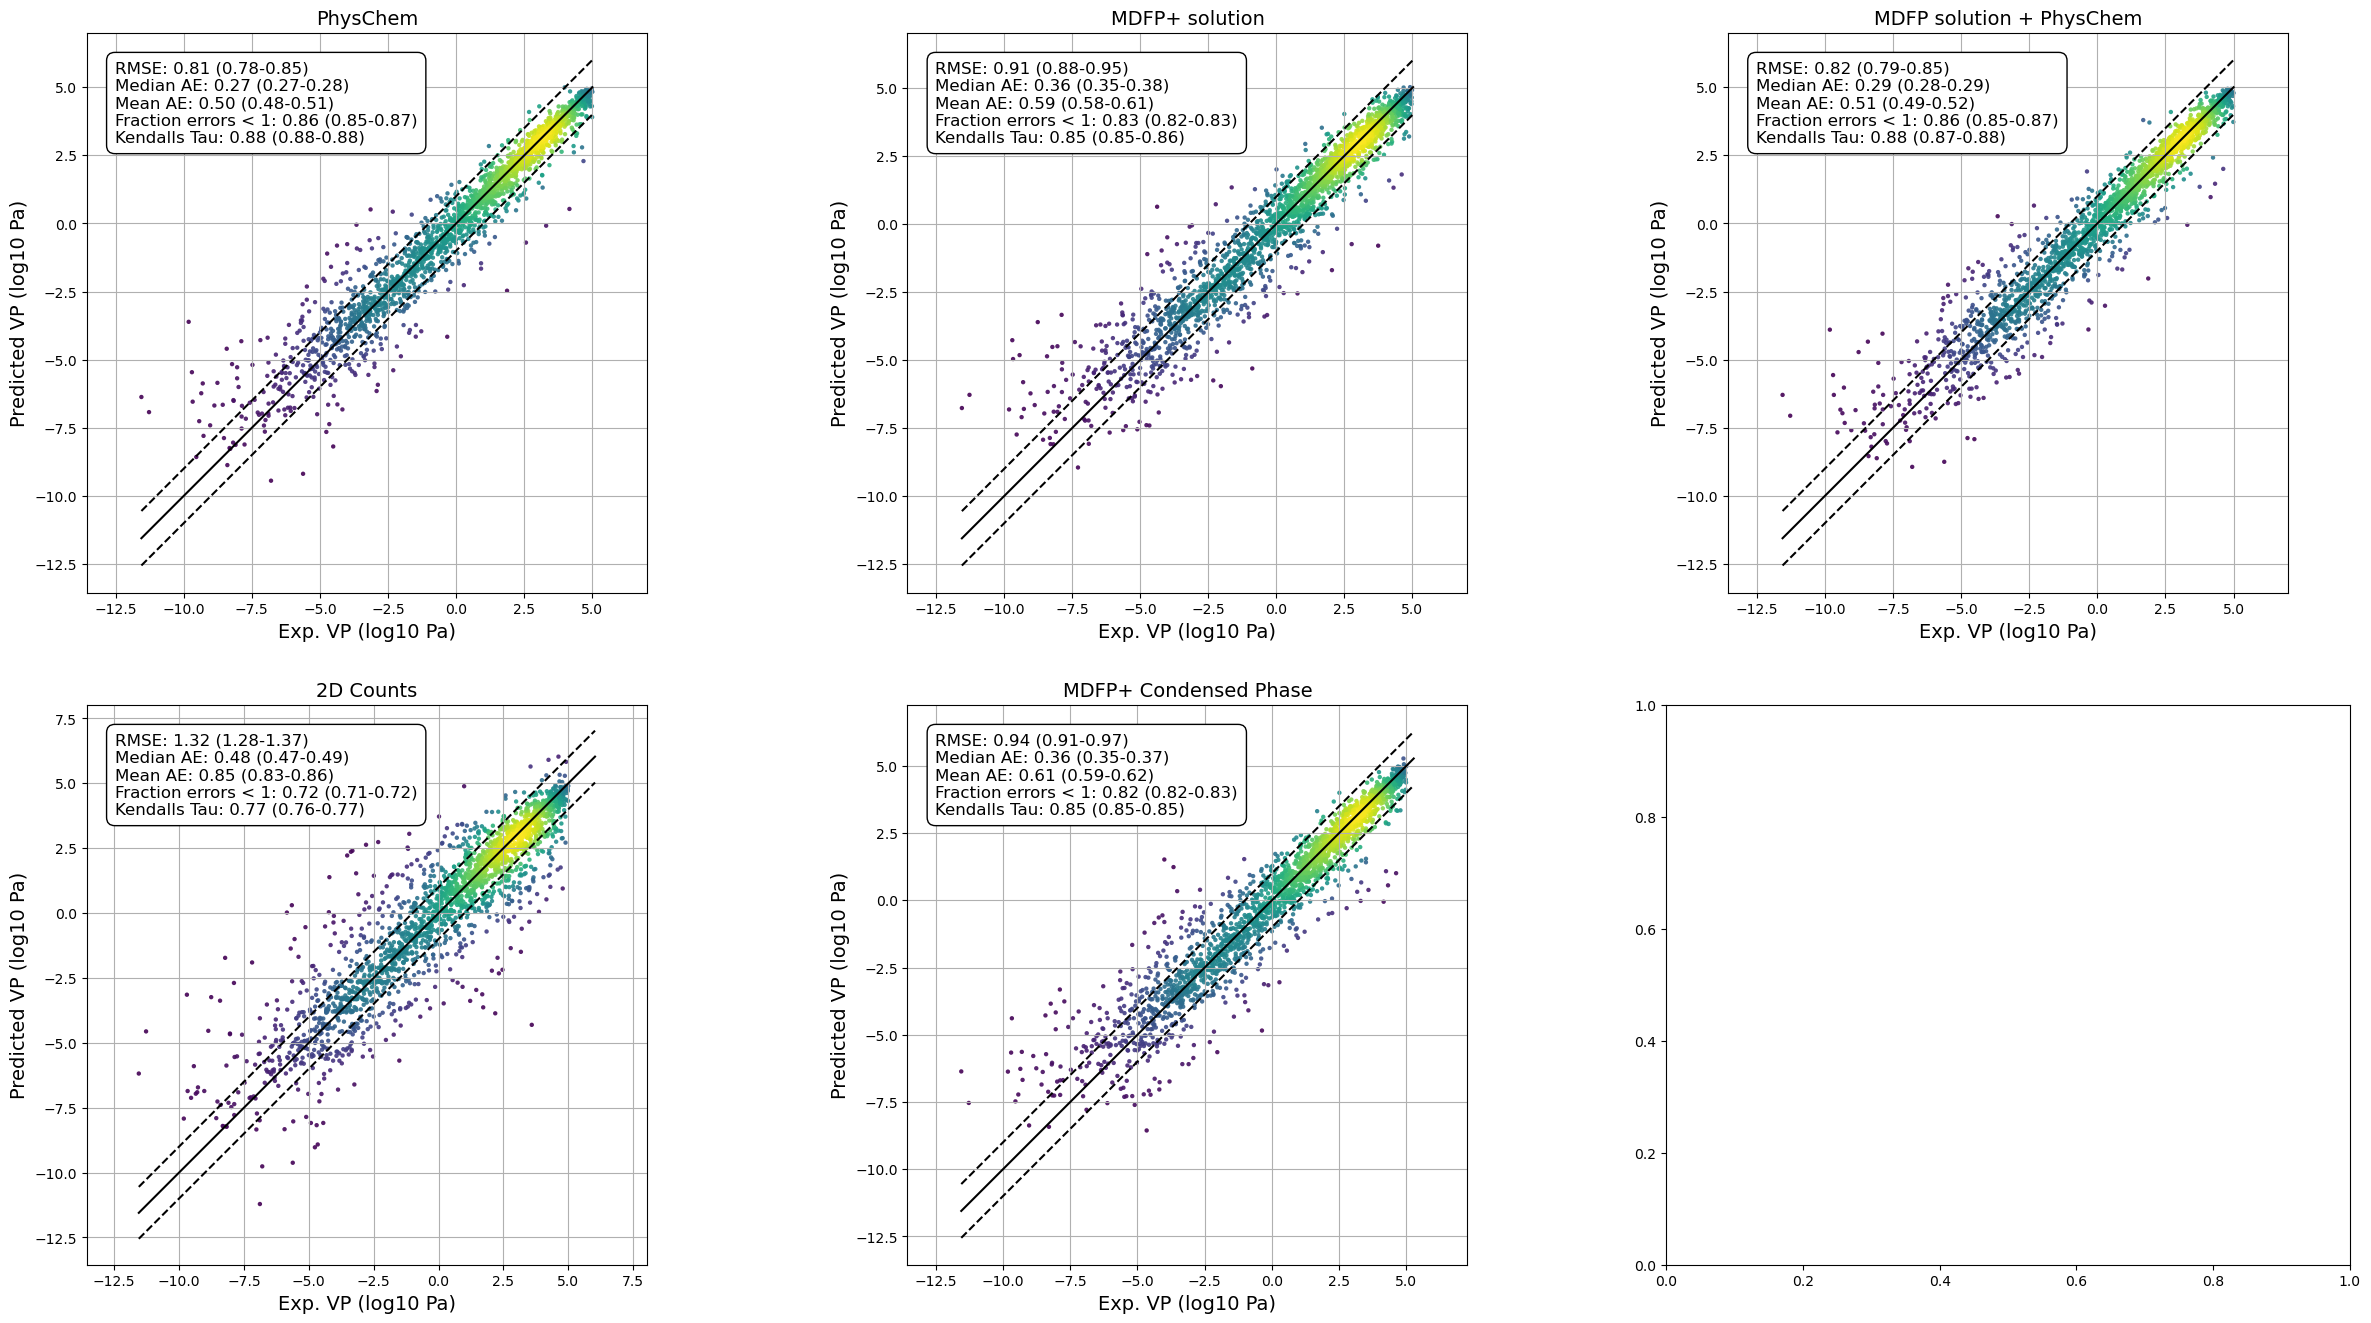

In [15]:

reals_list = [ys_list_xgboost_physchem, ys_list_xgboost_mdfp_plus, ys_list_xgboost_mdfp_and_physchem, ys_list_xgboost_mdfp_counts, ys_list_xgboost_mdfp_plus_condensed_phase]
predictions_list = [pred_list_xgboost_physchem, pred_list_xgboost_mdfp_plus, pred_list_xgboost_mdfp_and_physchem, pred_list_xgboost_mdfp_counts, pred_list_xgboost_mdfp_plus_condensed_phase]
molregnos_list = [molregnos_xgboost_physchem, molregnos_xgboost_mdfp_plus, molregnos_xgboost_mdfp_plus, molregnos_xgboost_mdfp_counts, molregnos_xgboost_mdfp_plus_condensed_phase]
title = ['PhysChem', 'MDFP+ Solution', 'MDFP Solution + PhysChem', '2D Counts', 'MDFP+ Condensed Phase']
density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, title=title, name='XGBoost_MDFP_PhysChem_2DCounts_CondensedPhase', dims=(2,3))


In [18]:
#make df with combined info. first make flat lists of preds ys and molregnos

# pred_list_xgboost_physchem_flat = [item for sublist in pred_list_xgboost_physchem for item in sublist]
# ys_list_xgboost_physchem_flat = [item for sublist in ys_list_xgboost_physchem for item in sublist]
# molregnos_xgboost_physchem_flat = [item for sublist in molregnos_xgboost_physchem for item in sublist]
# df_results_xgboost_physchem = pd.DataFrame({'Pred_Physchem': pred_list_xgboost_physchem_flat, 'vp_log10_pa': ys_list_xgboost_physchem_flat, 'molregno': molregnos_xgboost_physchem_flat})
# pred_list_xgboost_mdfp_plus_flat = [item for sublist in pred_list_xgboost_mdfp_plus for item in sublist]
# ys_list_xgboost_mdfp_plus_flat = [item for sublist in ys_list_xgboost_mdfp_plus for item in sublist]
# molregnos_xgboost_mdfp_plus_flat = [item for sublist in molregnos_xgboost_mdfp_plus for item in sublist]
# df_results_xgboost_mdfp_plus = pd.DataFrame({'Pred_MDFP': pred_list_xgboost_mdfp_plus_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_plus_flat, 'molregno': molregnos_xgboost_mdfp_plus_flat})
# pred_list_xgboost_mdfp_and_physchem_flat = [item for sublist in pred_list_xgboost_mdfp_and_physchem for item in sublist]
# ys_list_xgboost_mdfp_and_physchem_flat = [item for sublist in ys_list_xgboost_mdfp_and_physchem for item in sublist]
# molregnos_xgboost_mdfp_and_physchem_flat = [item for sublist in molregnos_xgboost_mdfp_and_physchem for item in sublist]
# df_results_xgboost_mdfp_and_physchem = pd.DataFrame({'Pred_MDFP_Physchem': pred_list_xgboost_mdfp_and_physchem_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_and_physchem_flat, 'molregno': molregnos_xgboost_mdfp_and_physchem_flat})
# #combine into one df
# df_results = pd.concat([df_results_xgboost_physchem, df_results_xgboost_mdfp_plus, df_results_xgboost_mdfp_and_physchem], axis=1)
# df_results = df_results.loc[:,~df_results.columns.duplicated()]
# #vp_log10_pa as float, all preds as floats
# df_results['vp_log10_pa'] = df_results['vp_log10_pa'].astype(float)
# df_results['Pred_Physchem'] = df_results['Pred_Physchem'].astype(float)
# df_results['Pred_MDFP'] = df_results['Pred_MDFP'].astype(float)
# df_results['Pred_MDFP_Physchem'] = df_results['Pred_MDFP_Physchem'].astype(float)
# # #add column error PhysChem, error MDFP, error MDFP_PhysChem
# df_results['error_PhysChem'] = df_results['vp_log10_pa'] - df_results['Pred_Physchem']
# df_results['error_MDFP'] = df_results['vp_log10_pa'] - df_results['Pred_MDFP']
# df_results['error_MDFP_PhysChem'] = df_results['vp_log10_pa'] - df_results['Pred_MDFP_Physchem']
# df_results
# #save
# df_results.to_csv('splits/predictions/OPERA_Naef_XGBoost_PhysChem_MDFP_MDFP_PhysChem.csv', index=False)

pred_list_xgboost_mdfp_and_physchem_flat = [item for sublist in pred_list_xgboost_mdfp_and_physchem for item in sublist]
ys_list_xgboost_mdfp_and_physchem_flat = [item for sublist in ys_list_xgboost_mdfp_and_physchem for item in sublist]
molregnos_xgboost_mdfp_and_physchem_flat = [item for sublist in molregnos_xgboost_mdfp_and_physchem for item in sublist]
df_results_xgboost_mdfp_and_physchem = pd.DataFrame({'Pred_MDFP_Physchem': pred_list_xgboost_mdfp_and_physchem_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_and_physchem_flat, 'molregno': molregnos_xgboost_mdfp_and_physchem_flat})
pred_list_xgboost_mdfp_counts_flat = [item for sublist in pred_list_xgboost_mdfp_counts for item in sublist]
ys_list_xgboost_mdfp_counts_flat = [item for sublist in ys_list_xgboost_mdfp_counts for item in sublist]
molregnos_xgboost_mdfp_counts_flat = [item for sublist in molregnos_xgboost_mdfp_counts for item in sublist]
df_results_xgboost_mdfp_counts = pd.DataFrame({'Pred_MDFP_Counts': pred_list_xgboost_mdfp_counts_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_counts_flat, 'molregno': molregnos_xgboost_mdfp_counts_flat})
pred_list_xgboost_mdfp_plus_condensed_phase_flat = [item for sublist in pred_list_xgboost_mdfp_plus_condensed_phase for item in sublist]
ys_list_xgboost_mdfp_plus_condensed_phase_flat = [item for sublist in ys_list_xgboost_mdfp_plus_condensed_phase for item in sublist]
molregnos_xgboost_mdfp_plus_condensed_phase_flat = [item for sublist in molregnos_xgboost_mdfp_plus_condensed_phase for item in sublist]
df_results_xgboost_mdfp_plus_condensed_phase = pd.DataFrame({'Pred_MDFP_Condensed': pred_list_xgboost_mdfp_plus_condensed_phase_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_plus_condensed_phase_flat, 'molregno': molregnos_xgboost_mdfp_plus_condensed_phase_flat})
pred_list_xgboost_mdfp_plus_flat = [item for sublist in pred_list_xgboost_mdfp_plus for item in sublist]
ys_list_xgboost_mdfp_plus_flat = [item for sublist in ys_list_xgboost_mdfp_plus for item in sublist]
molregnos_xgboost_mdfp_plus_flat = [item for sublist in molregnos_xgboost_mdfp_plus for item in sublist]
df_results_xgboost_mdfp_plus = pd.DataFrame({'Pred_MDFP_solution': pred_list_xgboost_mdfp_plus_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_plus_flat, 'molregno': molregnos_xgboost_mdfp_plus_flat})
#combine into one df
df_results = pd.concat([df_results_xgboost_mdfp_and_physchem, df_results_xgboost_mdfp_counts, df_results_xgboost_mdfp_plus_condensed_phase, df_results_xgboost_mdfp_plus], axis=1)
df_results = df_results.loc[:,~df_results.columns.duplicated()]
#vp_log10_pa as float, all preds as floats
df_results['vp_log10_pa'] = df_results['vp_log10_pa'].astype(float)
df_results['Pred_MDFP_Physchem'] = df_results['Pred_MDFP_Physchem'].astype(float)
df_results['Pred_MDFP_Counts'] = df_results['Pred_MDFP_Counts'].astype(float)
df_results['Pred_MDFP_Condensed'] = df_results['Pred_MDFP_Condensed'].astype(float)
df_results['Pred_MDFP_solution'] = df_results['Pred_MDFP_solution'].astype(float)
# #add column error PhysChem, error MDFP, error MDFP_PhysChem
df_results['error_MDFP_PhysChem'] = df_results['vp_log10_pa'] - df_results['Pred_MDFP_Physchem']
df_results['error_MDFP_Counts'] = df_results['vp_log10_pa'] - df_results['Pred_MDFP_Counts']
df_results['error_MDFP_Phase'] = df_results['vp_log10_pa'] - df_results['Pred_MDFP_Condensed']
df_results['error_MDFP_solution'] = df_results['vp_log10_pa'] - df_results['Pred_MDFP_solution']
df_results


,Pred_MDFP_Physchem,vp_log10_pa,molregno,Pred_MDFP_Counts,Pred_MDFP_Condensed,Pred_MDFP_solution,error_MDFP_PhysChem,error_MDFP_Counts,error_MDFP_Phase,error_MDFP_solution
0,-1.764806,-1.185798,922,1.162803,0.883638,-1.659055,0.579007,-2.348601,-2.069436,0.473256
1,3.346962,3.526402,959,3.394494,3.423589,3.554626,0.179440,0.131908,0.102813,-0.028224
2,2.659371,2.601702,4096,2.690680,2.586287,2.450222,-0.057669,-0.088978,0.015415,0.151480
3,1.045998,2.086002,475,0.680686,0.768614,0.339447,1.040004,1.405316,1.317388,1.746555
4,1.068199,-0.319998,16902,1.037777,1.353664,0.887585,-1.388197,-1.357775,-1.673661,-1.207583
...,...,...,...,...,...,...,...,...,...,...
5215,-2.249775,-5.480597,23,-4.050280,-4.195035,-4.287328,-3.230823,-1.430318,-1.285562,-1.193269
5216,4.540189,4.662000,15895,3.959265,4.334684,4.496116,0.121811,0.702735,0.327316,0.165884
5217,3.036871,2.572102,138,1.179250,2.336259,2.368921,-0.464769,1.392851,0.235843,0.203181
5218,2.543361,2.421000,16307,2.546156,2.342493,2.361558,-0.122361,-0.125156,0.078507,0.059442


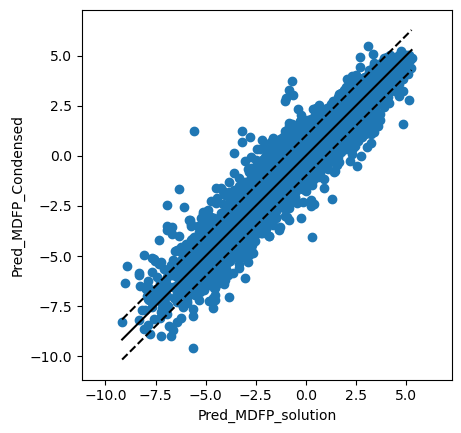

RMSE: 0.7588378700283364, MAE: 0.5203653180880862, EBO: 0.8521072796934865, KT: 0.8572406011339353, median_AE: 0.34482021629810333


In [24]:
#plot Pred_MDFP_solution against Pred_MDFP_Condensed
plt.scatter(df_results['Pred_MDFP_solution'], df_results['Pred_MDFP_Condensed'])
plt.xlabel('Pred_MDFP_solution')
plt.ylabel('Pred_MDFP_Condensed')
#diagonal, +- 1 lines
plt.plot([min(df_results['Pred_MDFP_solution']), max(df_results['Pred_MDFP_solution'])], [min(df_results['Pred_MDFP_solution']), max(df_results['Pred_MDFP_solution'])], 'k-')
plt.plot([min(df_results['Pred_MDFP_solution']), max(df_results['Pred_MDFP_solution'])], [min(df_results['Pred_MDFP_solution']) - 1, max(df_results['Pred_MDFP_solution']) - 1], 'k--')
plt.plot([min(df_results['Pred_MDFP_solution']), max(df_results['Pred_MDFP_solution'])], [min(df_results['Pred_MDFP_solution']) + 1, max(df_results['Pred_MDFP_solution']) + 1], 'k--')
#equal aspect ratio
plt.xlim([min(df_results['Pred_MDFP_solution']) - 2, max(df_results['Pred_MDFP_solution']) + 2])
plt.ylim([min(df_results['Pred_MDFP_solution']) - 2, max(df_results['Pred_MDFP_solution']) + 2])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#get stats
RMSE, MAE, EBO, KT, median_AE = getStatValues_v2(df_results['Pred_MDFP_solution'], df_results['Pred_MDFP_Condensed'])
print(f'RMSE: {RMSE}, MAE: {MAE}, EBO: {EBO}, KT: {KT}, median_AE: {median_AE}')